# Multi-Class Classification with Transformer Encoder

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
import sklearn.datasets
import umap
import umap.plot
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device('cuda:1')
T.__version__, device, device2

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


('1.12.1', device(type='cuda'), device(type='cuda', index=1))

## 1. Making Dataset

### 1-1. Trim & Sort

In [2]:
df = pd.read_pickle('xy_STAD-related-only.pkl')
df

,submitter_id.samples,neoplasm_histologic_grade,ENSG00000134982.15,ENSG00000132781.16,ENSG00000125347.12,ENSG00000003400.13,ENSG00000133703.10,ENSG00000141736.12,ENSG00000066468.19,ENSG00000121879.3,...,ENSG00000253293.4,ENSG00000145545.10,ENSG00000167711.12,ENSG00000142627.12,ENSG00000254324.2,ENSG00000138398.14,ENSG00000119699.6,ENSG00000157456.6,ENSG00000068024.15,ENSG00000134363.10
0,TCGA-3M-AB46-01A,G2,15.079514,17.414938,17.365214,18.054834,17.592039,19.026159,16.988659,16.226403,...,17.643056,16.048125,13.748551,19.140727,0.000000,19.716016,14.956674,18.032511,14.852806,15.970329
1,TCGA-3M-AB47-01A,G3,16.812603,15.904570,18.298847,17.441156,18.036434,17.735773,16.097251,16.448956,...,17.142189,16.711625,13.987007,17.774903,0.000000,18.439536,16.723031,17.929792,15.743926,14.681749
2,TCGA-B7-5818-01A,G3,15.642202,15.912011,18.662111,16.382809,17.797608,19.516644,19.218607,15.731698,...,8.465146,15.375221,13.611846,19.264462,0.000000,17.597394,15.407592,18.542210,15.690110,13.305037
3,TCGA-B7-A5TI-01A,G3,16.060210,16.614935,16.654159,16.730176,17.937752,19.660434,18.737403,16.487452,...,12.900149,14.896727,13.625237,20.652489,0.000000,18.122521,16.680127,18.186631,14.732920,13.788227
4,TCGA-B7-A5TJ-01A,G1,15.719877,16.525847,17.006665,16.876615,17.559441,18.943163,17.838738,15.858206,...,17.788447,15.391023,14.555349,19.661662,0.000000,18.708507,14.416826,17.942503,15.696291,13.368884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,TCGA-VQ-AA6G-01A,G2,17.333125,16.562825,18.292577,19.014720,18.792734,24.963099,15.413158,16.429962,...,16.563982,15.989235,13.872869,21.200319,12.977412,18.274041,13.483963,17.799114,15.512751,13.218604
403,TCGA-VQ-AA6J-01A,G3,16.254265,16.554167,18.734580,17.640446,17.564258,18.318130,16.909481,16.487961,...,17.311090,17.137654,14.648029,19.193336,11.934916,18.373492,16.428333,18.855995,15.799059,12.013845
404,TCGA-VQ-AA6K-01A,G3,16.784325,15.890133,18.029975,17.364764,18.153768,19.371017,16.453277,16.109959,...,11.525179,14.845428,16.367526,19.029468,11.486411,18.358351,15.091318,17.980454,16.267145,13.485548
405,TCGA-ZA-A8F6-01A,G2,16.693416,16.193612,17.997426,17.702167,17.058265,19.367424,16.519393,16.049621,...,16.266644,15.442653,14.040467,18.798104,12.636054,18.405897,16.416531,17.356693,16.687620,13.057337


In [3]:
df.columns[2:]

Index(['ENSG00000134982.15', 'ENSG00000132781.16', 'ENSG00000125347.12',
       'ENSG00000003400.13', 'ENSG00000133703.10', 'ENSG00000141736.12',
       'ENSG00000066468.19', 'ENSG00000121879.3', 'ENSG00000067082.13',
       'ENSG00000136689.17',
       ...
       'ENSG00000253293.4', 'ENSG00000145545.10', 'ENSG00000167711.12',
       'ENSG00000142627.12', 'ENSG00000254324.2', 'ENSG00000138398.14',
       'ENSG00000119699.6', 'ENSG00000157456.6', 'ENSG00000068024.15',
       'ENSG00000134363.10'],
      dtype='object', length=843)

In [4]:
# 유전자위치번호에서 소수점이하 버린 리스트를 만들고
gene_locations_trimmed = [gene_locations[:15] for gene_locations in df.columns[2:]]

In [5]:
# 그 리스트를 가지고 데이터프레임을 다시 만듦
for original, trimmed in zip(df.columns[2:], gene_locations_trimmed):
    df.rename(columns={original:trimmed}, inplace=True)
df

,submitter_id.samples,neoplasm_histologic_grade,ENSG00000134982,ENSG00000132781,ENSG00000125347,ENSG00000003400,ENSG00000133703,ENSG00000141736,ENSG00000066468,ENSG00000121879,...,ENSG00000253293,ENSG00000145545,ENSG00000167711,ENSG00000142627,ENSG00000254324,ENSG00000138398,ENSG00000119699,ENSG00000157456,ENSG00000068024,ENSG00000134363
0,TCGA-3M-AB46-01A,G2,15.079514,17.414938,17.365214,18.054834,17.592039,19.026159,16.988659,16.226403,...,17.643056,16.048125,13.748551,19.140727,0.000000,19.716016,14.956674,18.032511,14.852806,15.970329
1,TCGA-3M-AB47-01A,G3,16.812603,15.904570,18.298847,17.441156,18.036434,17.735773,16.097251,16.448956,...,17.142189,16.711625,13.987007,17.774903,0.000000,18.439536,16.723031,17.929792,15.743926,14.681749
2,TCGA-B7-5818-01A,G3,15.642202,15.912011,18.662111,16.382809,17.797608,19.516644,19.218607,15.731698,...,8.465146,15.375221,13.611846,19.264462,0.000000,17.597394,15.407592,18.542210,15.690110,13.305037
3,TCGA-B7-A5TI-01A,G3,16.060210,16.614935,16.654159,16.730176,17.937752,19.660434,18.737403,16.487452,...,12.900149,14.896727,13.625237,20.652489,0.000000,18.122521,16.680127,18.186631,14.732920,13.788227
4,TCGA-B7-A5TJ-01A,G1,15.719877,16.525847,17.006665,16.876615,17.559441,18.943163,17.838738,15.858206,...,17.788447,15.391023,14.555349,19.661662,0.000000,18.708507,14.416826,17.942503,15.696291,13.368884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,TCGA-VQ-AA6G-01A,G2,17.333125,16.562825,18.292577,19.014720,18.792734,24.963099,15.413158,16.429962,...,16.563982,15.989235,13.872869,21.200319,12.977412,18.274041,13.483963,17.799114,15.512751,13.218604
403,TCGA-VQ-AA6J-01A,G3,16.254265,16.554167,18.734580,17.640446,17.564258,18.318130,16.909481,16.487961,...,17.311090,17.137654,14.648029,19.193336,11.934916,18.373492,16.428333,18.855995,15.799059,12.013845
404,TCGA-VQ-AA6K-01A,G3,16.784325,15.890133,18.029975,17.364764,18.153768,19.371017,16.453277,16.109959,...,11.525179,14.845428,16.367526,19.029468,11.486411,18.358351,15.091318,17.980454,16.267145,13.485548
405,TCGA-ZA-A8F6-01A,G2,16.693416,16.193612,17.997426,17.702167,17.058265,19.367424,16.519393,16.049621,...,16.266644,15.442653,14.040467,18.798104,12.636054,18.405897,16.416531,17.356693,16.687620,13.057337


In [ ]:
# 컬럼 이름 오름차순으로 데이터프레임 정렬(나중에 새로운 데이터로 추론시에 유전자위치가 섞여 있으면 안 되기 때문)
dfs = df.sort_index(axis=1)
dfs

,ENSG00000001036,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,ENSG00000007306,ENSG00000007908,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
0,20.220979,18.727956,18.054834,16.883271,17.770933,17.075150,19.532668,12.899567,21.546847,12.727316,...,9.415178,13.167983,0.000000,13.485292,13.578557,0.000000,15.438352,8.090678,G2,TCGA-3M-AB46-01A
1,18.500387,18.090443,17.441156,17.084666,17.911313,17.918745,17.848073,20.369232,17.534968,13.302473,...,10.799621,11.281136,0.000000,14.944210,11.546818,0.000000,12.354517,8.889208,G3,TCGA-3M-AB47-01A
2,19.761280,19.709574,16.382809,17.009260,18.338054,0.000000,19.286103,15.615647,20.880475,11.402849,...,11.088938,14.599826,8.546172,12.620040,13.064786,0.000000,15.455768,9.762250,G3,TCGA-B7-5818-01A
3,19.181518,18.942790,16.730176,17.504471,18.743804,13.404958,19.960137,14.335578,13.743663,17.015218,...,10.703615,13.796031,7.579382,13.917905,11.974194,0.000000,16.328196,0.000000,G3,TCGA-B7-A5TI-01A
4,19.586652,18.527097,16.876615,16.508963,18.322003,12.930491,18.587707,14.618427,16.891622,12.864853,...,10.185077,12.604413,10.960521,14.445830,12.838448,9.294717,16.457270,0.000000,G1,TCGA-B7-A5TJ-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,18.996392,17.717748,19.014720,17.760508,18.895264,11.843199,18.821252,20.924100,17.296007,16.393388,...,8.973679,13.890051,7.433210,14.811144,12.551461,0.000000,15.849008,9.230485,G2,TCGA-VQ-AA6G-01A
403,18.794649,17.603730,17.640446,17.107674,17.772747,12.009924,17.793565,16.328723,18.055424,14.841340,...,10.099362,14.217296,8.969995,14.709362,13.369268,0.000000,15.227504,9.187872,G3,TCGA-VQ-AA6J-01A
404,19.295330,17.706194,17.364764,17.483705,18.701045,11.352034,19.956168,13.972806,20.509458,13.452614,...,11.649856,11.868503,10.104749,15.562842,12.255207,0.000000,17.192497,8.740135,G3,TCGA-VQ-AA6K-01A
405,18.647983,18.393344,17.702167,17.343445,18.016156,14.130838,18.504918,19.475805,12.394146,13.835164,...,10.215577,11.918873,0.000000,15.733577,12.591478,0.000000,14.480349,0.000000,G2,TCGA-ZA-A8F6-01A


In [7]:
# 정답값이 되는 악성 종양 등급 별로 행 정렬(훈련,검증데이터로 나눌 때 필요)
dfs2 = dfs.sort_values(by='neoplasm_histologic_grade')
dfs2

,ENSG00000001036,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,ENSG00000007306,ENSG00000007908,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
318,20.219629,19.121479,17.287974,16.630257,18.423464,19.828220,19.216307,15.708156,14.225520,12.588927,...,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000,G1,TCGA-KB-A93H-01A
317,18.819095,17.963353,16.261201,18.064107,18.742024,14.194581,17.918124,16.411844,13.153777,17.957511,...,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656,G1,TCGA-KB-A93G-01A
132,19.807727,19.515146,17.236227,16.513151,17.901542,15.226351,16.193370,15.621697,17.307695,13.244725,...,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000,G1,TCGA-CD-5800-01A
179,18.941061,19.171449,16.252021,17.308548,18.033843,18.545737,18.558169,13.269680,15.130262,16.910450,...,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310,G1,TCGA-CG-5719-01A
258,19.919778,18.456981,17.296716,16.551752,17.765063,10.902787,18.113180,16.785000,18.713718,11.629097,...,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000,G1,TCGA-HU-8244-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,18.851856,16.423086,17.029071,17.873540,17.380176,16.748492,12.067423,10.471021,11.404887,...,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719,GX,TCGA-BR-8297-01A
378,20.160689,17.841738,17.806221,17.092400,17.932093,13.823015,19.435108,16.823552,15.717842,14.174856,...,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506,GX,TCGA-VQ-A91S-01A
344,19.631296,18.765269,17.731691,17.073518,18.011159,19.196995,13.348575,17.490483,14.895278,9.664963,...,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776,GX,TCGA-SW-A7EA-01A
50,19.331497,18.370031,16.306453,17.176000,17.556664,17.652474,18.865459,12.446429,17.184552,14.755209,...,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000,GX,TCGA-BR-7197-01A


In [8]:
dfs2.to_pickle('xy_STAD-related_trimmed_sorted.pkl')
dfs2.to_csv('xy_STAD-related_trimmed_sorted.csv')

In [128]:
dfs2 = pd.read_pickle('xy_STAD-related_trimmed_sorted.pkl')
dfs2

,ENSG00000001036,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,ENSG00000007306,ENSG00000007908,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
318,20.219629,19.121479,17.287974,16.630257,18.423464,19.828220,19.216307,15.708156,14.225520,12.588927,...,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000,G1,TCGA-KB-A93H-01A
317,18.819095,17.963353,16.261201,18.064107,18.742024,14.194581,17.918124,16.411844,13.153777,17.957511,...,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656,G1,TCGA-KB-A93G-01A
132,19.807727,19.515146,17.236227,16.513151,17.901542,15.226351,16.193370,15.621697,17.307695,13.244725,...,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000,G1,TCGA-CD-5800-01A
179,18.941061,19.171449,16.252021,17.308548,18.033843,18.545737,18.558169,13.269680,15.130262,16.910450,...,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310,G1,TCGA-CG-5719-01A
258,19.919778,18.456981,17.296716,16.551752,17.765063,10.902787,18.113180,16.785000,18.713718,11.629097,...,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000,G1,TCGA-HU-8244-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,18.851856,16.423086,17.029071,17.873540,17.380176,16.748492,12.067423,10.471021,11.404887,...,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719,GX,TCGA-BR-8297-01A
378,20.160689,17.841738,17.806221,17.092400,17.932093,13.823015,19.435108,16.823552,15.717842,14.174856,...,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506,GX,TCGA-VQ-A91S-01A
344,19.631296,18.765269,17.731691,17.073518,18.011159,19.196995,13.348575,17.490483,14.895278,9.664963,...,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776,GX,TCGA-SW-A7EA-01A
50,19.331497,18.370031,16.306453,17.176000,17.556664,17.652474,18.865459,12.446429,17.184552,14.755209,...,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000,GX,TCGA-BR-7197-01A


### 1-2. Extracting dataset X & Y

In [10]:
df_X = dfs2.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
df_X

,ENSG00000001036,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,ENSG00000007306,ENSG00000007908,...,ENSG00000278195,ENSG00000278535,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450
318,20.219629,19.121479,17.287974,16.630257,18.423464,19.828220,19.216307,15.708156,14.225520,12.588927,...,9.050980,17.168656,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000
317,18.819095,17.963353,16.261201,18.064107,18.742024,14.194581,17.918124,16.411844,13.153777,17.957511,...,9.022631,14.459412,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656
132,19.807727,19.515146,17.236227,16.513151,17.901542,15.226351,16.193370,15.621697,17.307695,13.244725,...,10.417914,18.384390,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000
179,18.941061,19.171449,16.252021,17.308548,18.033843,18.545737,18.558169,13.269680,15.130262,16.910450,...,9.660372,16.680435,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310
258,19.919778,18.456981,17.296716,16.551752,17.765063,10.902787,18.113180,16.785000,18.713718,11.629097,...,6.906113,18.577989,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,18.851856,16.423086,17.029071,17.873540,17.380176,16.748492,12.067423,10.471021,11.404887,...,8.587089,15.852312,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719
378,20.160689,17.841738,17.806221,17.092400,17.932093,13.823015,19.435108,16.823552,15.717842,14.174856,...,11.013553,17.865388,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506
344,19.631296,18.765269,17.731691,17.073518,18.011159,19.196995,13.348575,17.490483,14.895278,9.664963,...,0.000000,16.218051,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776
50,19.331497,18.370031,16.306453,17.176000,17.556664,17.652474,18.865459,12.446429,17.184552,14.755209,...,7.457240,15.668101,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000


In [11]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 318 to 66
Columns: 843 entries, ENSG00000001036 to ENSG00000281450
dtypes: float64(843)
memory usage: 2.6 MB


In [16]:
df_Y = dfs2[['neoplasm_histologic_grade']]
df_Y

,neoplasm_histologic_grade
318,G1
317,G1
132,G1
179,G1
258,G1
...,...
82,GX
378,GX
344,GX
50,GX


In [17]:
df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 318 to 66
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   neoplasm_histologic_grade  407 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB


In [13]:
df_Y.shape

(407, 1)

In [12]:
print('G1:  ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G1']))
print('G2: ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G2']))
print('G3: ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G3']))
print('GX:   ', len(df_Y[df_Y['neoplasm_histologic_grade']=='GX']))

G1:   10
G2:  150
G3:  238
GX:    9


In [19]:
# NLL Loss 계산 시 문제가 생겨 label 차원은 평범한 1D가 되게 바꿈 
df_Y = dfs2['neoplasm_histologic_grade']
df_Y

318    G1
317    G1
132    G1
179    G1
258    G1
       ..
82     GX
378    GX
344    GX
50     GX
66     GX
Name: neoplasm_histologic_grade, Length: 407, dtype: object

In [22]:
df_Y.shape, len(df_Y)

((407,), 407)

### 1-3. Splitting dataset into train, val, test 

In [23]:
# X, Y 데이터를 약 7 : 2 : 1 의 비율로 나눔
df_X_train = pd.concat([df_X[0: 7], df_X[ 10:115], df_X[160:327], df_X[398:404]])
df_X_val   = pd.concat([df_X[7: 9], df_X[115:145], df_X[327:375], df_X[404:406]])
df_X_test  = pd.concat([df_X[9:10], df_X[145:160], df_X[375:398], df_X[406:407]])
df_Y_train = pd.concat([df_Y[0: 7], df_Y[ 10:115], df_Y[160:327], df_Y[398:404]])
df_Y_val   = pd.concat([df_Y[7: 9], df_Y[115:145], df_Y[327:375], df_Y[404:406]])
df_Y_test  = pd.concat([df_Y[9:10], df_Y[145:160], df_Y[375:398], df_Y[406:407]])

In [65]:
len(df_Y_train)+len(df_Y_val)+len(df_Y_test)

407

In [66]:
# X 데이터 : pandas dataframe 형식에서 numpy array 형식으로 변환
X_train = df_X_train.to_numpy(dtype='float32')
X_val = df_X_val.to_numpy(dtype='float32')
X_test = df_X_test.to_numpy(dtype='float32')
X_train.shape, X_train[0].dtype

((285, 843), dtype('float32'))

In [67]:
# Y 데이터 : 문자에서 정수로 변환 G1->1, G2->2, G3->3, GX->0
Y_train = df_Y_train.replace({'G1':1, 'G2':2, 'G3':3, 'GX':0}).to_numpy(dtype='int8')
Y_val = df_Y_val.replace({'G1':1, 'G2':2, 'G3':3, 'GX':0}).to_numpy(dtype='int8')
Y_test = df_Y_test.replace({'G1':1, 'G2':2, 'G3':3, 'GX':0}).to_numpy(dtype='int8')
Y_train.shape, Y_train[0].dtype

((285,), dtype('int8'))

### 1-4. Save datasets in 3 different ways

In [68]:
# 1. train:val:test 가 7:2:1 로 나뉜 데이터를 전부 가지고 있는 파일
hf = h5py.File('STAD_Dataset_split_in_three.h5', 'w')
hf.create_dataset('X_train', data=X_train)
hf.create_dataset('X_val', data=X_val)
hf.create_dataset('X_test', data=X_test)
hf.create_dataset('Y_train', data=Y_train)
hf.create_dataset('Y_val', data=Y_val)
hf.create_dataset('Y_test', data=Y_test)
hf.close()

In [69]:
X_Train = np.concatenate([X_train, X_test])
X_Train.shape

(325, 843)

In [70]:
Y_Train = np.concatenate([Y_train, Y_test])
Y_Train.shape

(325,)

In [71]:
# 2. 위 train+test 를 합친 전체의 80% 인 Train 데이터파일 
hf = h5py.File('STAD_Dataset_Train.h5', 'w')
hf.create_dataset('X_Train', data=X_Train)
hf.create_dataset('Y_Train', data=Y_Train)
hf.close()

In [72]:
# 3. 나머지 20% 만 가진 Test 데이터파일 
hf = h5py.File('STAD_Dataset_Test.h5', 'w')
hf.create_dataset('X_Test', data=X_val)
hf.create_dataset('Y_Test', data=Y_val)
hf.close()

### 1-5. Dataset Validation Check

In [32]:
hf = h5py.File('STAD_Dataset_split_in_three.h5', 'r')
# hf.keys()
X_train = np.array(hf.get('X_train'))
X_val = np.array(hf.get('X_val'))
X_test = np.array(hf.get('X_test'))
Y_train = np.array(hf.get('Y_train'))
Y_val = np.array(hf.get('Y_val'))
Y_test = np.array(hf.get('Y_test'))

print('X_train.shape : ', X_train.shape)
print('X_val.shape   : ', X_val.shape)
print('X_test.shape  : ', X_test.shape)
print('Y_train.shape : ', Y_train.shape)
print('Y_val.shape   : ', Y_val.shape)
print('Y_test.shape  : ', Y_test.shape)

hf.close()

X_train.shape :  (285, 843)
X_val.shape   :  (82, 843)
X_test.shape  :  (40, 843)
Y_train.shape :  (285,)
Y_val.shape   :  (82,)
Y_test.shape  :  (40,)


In [3]:
hf = h5py.File('STAD_Dataset_Train.h5', 'r')

X_Train = np.array(hf.get('X_Train'))
Y_Train = np.array(hf.get('Y_Train'))
print(hf.keys())
print('X_Train.shape : ', X_Train.shape)
print('Y_Train.shape : ', Y_Train.shape)
print('X_Train' in hf.keys())

hf.close()

<KeysViewHDF5 ['X_Train', 'Y_Train']>
X_Train.shape :  (325, 843)
Y_Train.shape :  (325,)
True


In [30]:
X_Train.astype('int64')

array([[20, 19, 17, ...,  0, 14,  0],
       [18, 17, 16, ...,  0, 13,  8],
       [19, 19, 17, ...,  0, 16,  0],
       ...,
       [19, 17, 17, ...,  0, 16,  0],
       [19, 17, 17, ...,  0, 13,  0],
       [19, 17, 16, ..., 13, 14,  8]])

In [34]:
type(X_Train)

numpy.ndarray

In [124]:
hf = h5py.File('STAD_Dataset_Test.h5', 'r')
# hf.keys()
X_Test = np.array(hf.get('X_Test'))
Y_Test = np.array(hf.get('Y_Test'))

print('X_Test.shape  : ', X_Test.shape)
print('Y_Test.shape  : ', Y_Test.shape)

hf.close()

X_Test.shape  :  (82, 843)
Y_Test.shape  :  (82,)


In [92]:
X_Train[0].dtype, Y_Train[0].dtype

(dtype('float32'), dtype('int8'))

## 2. Implementing the Backbone of Transformer-based Classifier

In [4]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            X = np.array(hf.get('X_Train')).astype('int64')
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            X = np.array(hf.get('X_Test')).astype('int64')
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [5]:
class STAD_Dataset2(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            X = np.array(hf.get('X_Train')).astype('int64')
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            X = np.array(hf.get('X_Test')).astype('int64')
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        self.x_data = T.tensor(X, dtype=T.int64).to(device2)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device2)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [6]:
# 오리지널 트랜스포머의 embedding layer를 대체하는 특수 레이어 함수
# 데이터가 텍스트가 아닌 실수일 때에는 기존과는 다른 방식이 필요
class Special_Embedding_Layer(T.nn.Module):

    class Core(T.nn.Module):
        def __init__(self, n):
            super().__init__()
            self.weights = T.nn.Parameter(T.zeros((n, 1), dtype=T.float32))
            self.biases = T.nn.Parameter(T.tensor(n, dtype=T.float32))
            lim = 0.01
            T.nn.init.uniform_(self.weights, -lim, lim)
            T.nn.init.zeros_(self.biases)
      
        def forward(self, x):
            wx = T.mm(x, self.weights.t())
            v = T.add(wx, self.biases)
            return v
    

    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in = n_in; self.n_out = n_out
        if n_out % n_in != 0:
            print("Warning: n_out ought be divisible by n_in")
        n = n_out // n_in
        self.lst_modules = T.nn.ModuleList([Special_Embedding_Layer.Core(n) for i in range(n_in)])


    def forward(self, x):
        lst_nodes = []
        for i in range(self.n_in):
            xi = x[:,i].reshape(-1, 1)
            oupt = self.lst_modules[i](xi)
            lst_nodes.append(oupt)

        # for i in range(1, self.n_in):
        #     result = T.cat((result, lst_nodes[i]), 1)
        # 위와 같이 하면 이상하게 두 번째 것만 붙고 나머지는 안 되어서 할 수 없이 나눠서 함
        result = T.cat((lst_nodes[0], lst_nodes[1]), 1)
        for i in range(2, self.n_in):
            result = T.cat((result, lst_nodes[i]), 1)
        result = result.reshape(-1, self.n_out)

        return result

In [7]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=5000):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # allows state-save

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
# I = input feature ; D = imbedding dimension ; F = fc1 layer hidden node ; drop = dropout rate
I = 843 ; D = 4 ; F = 32 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 843 - 26976 - Transformer - 100 - 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=32
        # self.embed = Special_Embedding_Layer(I, I*D)  # 843 input features, each goes to 32 
        self.embed = T.nn.Embedding(I, D)  # 843 input features, each goes to 32 
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # 6 layers default
        # STAD Dataset has 843 input features per each sample
        self.dropout = nn.Dropout(drop)
        self.fc1 = T.nn.Linear(D*I, F)  # 32 hidden nodes
        self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        # self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes

    def forward(self, x):
        # x = 843 input features, fixed length
        z = self.embed(x)  # 843 inputs to 26976 embeds 
        z = z.reshape(-1, I, D)  # bat seq embed 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, xxx])
        z = self.dropout(z)
        z = T.tanh(self.fc1(z))
        z = self.dropout(z)
        z = T.log_softmax(self.fc2(z), dim=1)  # NLLLoss()
        return z

In [10]:
net = Transformer_Classifier().to(device)
net

Transformer_Classifier(
  (embed): Embedding(843, 4)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_fe

In [11]:
batchsize = 325
torchinfo.summary(net, input_size=(batchsize, 843),  dtypes=[T.long],
col_names=["input_size","output_size","num_params","params_percent","trainable"])
# col_names=["input_size","output_size","num_params","params_percent","kernel_size","mult_adds","trainable"]

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Param %                   Trainable
Transformer_Classifier                        [325, 843]                [325, 4]                  136                         0.12%                   True
├─Embedding: 1-1                              [325, 843]                [325, 843, 4]             3,372                       3.01%                   True
├─PositionalEncoding: 1-2                     [325, 843, 4]             [325, 843, 4]             --                             --                   --
│    └─Dropout: 2-1                           [325, 843, 4]             [325, 843, 4]             --                             --                   --
├─TransformerEncoder: 1-3                     [325, 843, 4]             [325, 843, 4]             --                             --                   True
│    └─ModuleList: 2-2                        --                     

## 3. Training model

### 3-1. Lodaing Dataset

In [12]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with 407 STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
print("\nCreating 325 training dataset from an h5 file")
train_file = "./STAD_Dataset_Train.h5"
train_ds = STAD_Dataset(train_file)

print("\nCreating 82 testdDataset from an h5 file")
test_file = "./STAD_Dataset_Test.h5"
test_ds = STAD_Dataset(test_file)

bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with 407 STAD samples 

Creating 325 training dataset from an h5 file

Creating 82 testdDataset from an h5 file


### 3-2. Training model

In [309]:
print("\nCreating Transformer network ")
net = Transformer_Classifier().to(device)
print("\nPreparation for model training complete.")

max_epochs = 35
ep_log_interval = 1
lrn_rate = 0.0001

loss_func = T.nn.NLLLoss()  # assumes log-softmax()
# optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = ", optimizer)
# print("lrn_rate = %0.5f " % lrn_rate)
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()  # set mode
for epoch in range(0, max_epochs):
    ep_loss = 0.0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d   |   loss = %9.4f" % (epoch, ep_loss))
        net.eval()

print("Done ") 


Creating Transformer network 

Preparation for model training complete.

bat_size =  10 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  35 

Starting training
epoch =    0   |   loss =   31.0292
epoch =    1   |   loss =   28.7754
epoch =    2   |   loss =   27.4288
epoch =    3   |   loss =   27.1975
epoch =    4   |   loss =   25.9889
epoch =    5   |   loss =   25.6563
epoch =    6   |   loss =   25.0458
epoch =    7   |   loss =   23.6449
epoch =    8   |   loss =   22.2072
epoch =    9   |   loss =   22.0701
epoch =   10   |   loss =   21.4549
epoch =   11   |   loss =   20.3009
epoch =   12   |   loss =   18.9018
epoch =   13   |   loss =   18.1488
epoch =   14   |   loss =   17.6822
epoch =   15   |   loss =   16.6895
epoch =   16   |   loss =   15.7051
epoch =   17   |   loss =   15.0152
epoch =   18 

## 4. Evaluating model

In [340]:
metric_collection = MetricCollection([
    MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])

In [345]:
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

{'MulticlassAccuracy': tensor(0.9877, device='cuda:0'),
 'MulticlassPrecision': tensor(0.9905, device='cuda:0'),
 'MulticlassRecall': tensor(0.9877, device='cuda:0'),
 'MulticlassF1Score': tensor(0.9884, device='cuda:0')}

In [346]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassAccuracy': tensor(0.5732, device='cuda:0'),
 'MulticlassPrecision': tensor(0.5293, device='cuda:0'),
 'MulticlassRecall': tensor(0.5732, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5409, device='cuda:0')}

In [267]:
net.eval()
with T.no_grad():
    output = net(train_ds.x_data)
train_ds.x_data.shape, output.shape

(torch.Size([325, 843]), torch.Size([325, 4]))

In [268]:
output[0]

tensor([-3.1239, -1.3624, -1.2079, -0.9134], device='cuda:0')

In [269]:
output[0].argmax(keepdim=True)

tensor([3], device='cuda:0')

In [270]:
output.shape

torch.Size([325, 4])

In [271]:
pred = output.argmax(dim=1, keepdim=True)
pred.shape

torch.Size([325, 1])

In [272]:
pred.squeeze(1).shape

torch.Size([325])

In [273]:
train_ds.y_data[0], train_ds.y_data.shape

(tensor(1, device='cuda:0'), torch.Size([325]))

### 4-1. Evaluating model with Train Dataset

In [347]:
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)

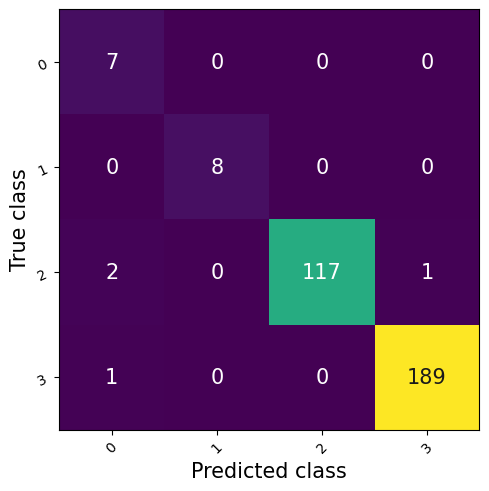

In [348]:
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [349]:
metric_collection(preds_train, target_train)

{'MulticlassAccuracy': tensor([1.0000, 1.0000, 0.9750, 0.9947], device='cuda:0'),
 'MulticlassPrecision': tensor([0.7000, 1.0000, 1.0000, 0.9947], device='cuda:0'),
 'MulticlassRecall': tensor([1.0000, 1.0000, 0.9750, 0.9947], device='cuda:0'),
 'MulticlassF1Score': tensor([0.8235, 1.0000, 0.9873, 0.9947], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

In [350]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)

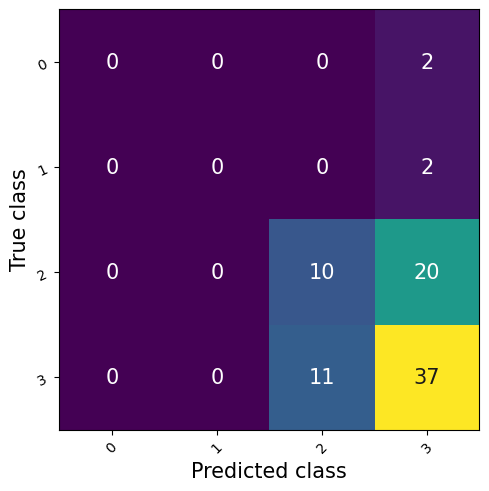

In [351]:
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [352]:
metric_collection(preds_test, target_test)

{'MulticlassAccuracy': tensor([0.0000, 0.0000, 0.3333, 0.7708], device='cuda:0'),
 'MulticlassPrecision': tensor([0.0000, 0.0000, 0.4762, 0.6066], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.3333, 0.7708], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.3922, 0.6789], device='cuda:0')}

## 5. Save model

In [330]:
file_name = "./Model_save/vanila-imbedding_Adam0001_D4_F32_dr1_withoutfc2.pt"
T.save(net.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


## 6. Visualize the latent space of networks using UMAP

In [116]:
reducer = umap.UMAP()

In [126]:
X_Train.shape

(325, 843)

In [131]:
df_X = dfs2.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
df_X

,ENSG00000001036,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,ENSG00000007306,ENSG00000007908,...,ENSG00000278195,ENSG00000278535,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450
318,20.219629,19.121479,17.287974,16.630257,18.423464,19.828220,19.216307,15.708156,14.225520,12.588927,...,9.050980,17.168656,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000
317,18.819095,17.963353,16.261201,18.064107,18.742024,14.194581,17.918124,16.411844,13.153777,17.957511,...,9.022631,14.459412,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656
132,19.807727,19.515146,17.236227,16.513151,17.901542,15.226351,16.193370,15.621697,17.307695,13.244725,...,10.417914,18.384390,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000
179,18.941061,19.171449,16.252021,17.308548,18.033843,18.545737,18.558169,13.269680,15.130262,16.910450,...,9.660372,16.680435,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310
258,19.919778,18.456981,17.296716,16.551752,17.765063,10.902787,18.113180,16.785000,18.713718,11.629097,...,6.906113,18.577989,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,18.851856,16.423086,17.029071,17.873540,17.380176,16.748492,12.067423,10.471021,11.404887,...,8.587089,15.852312,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719
378,20.160689,17.841738,17.806221,17.092400,17.932093,13.823015,19.435108,16.823552,15.717842,14.174856,...,11.013553,17.865388,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506
344,19.631296,18.765269,17.731691,17.073518,18.011159,19.196995,13.348575,17.490483,14.895278,9.664963,...,0.000000,16.218051,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776
50,19.331497,18.370031,16.306453,17.176000,17.556664,17.652474,18.865459,12.446429,17.184552,14.755209,...,7.457240,15.668101,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000


In [132]:
embedding = reducer.fit_transform(df_X)
embedding.shape

(407, 2)

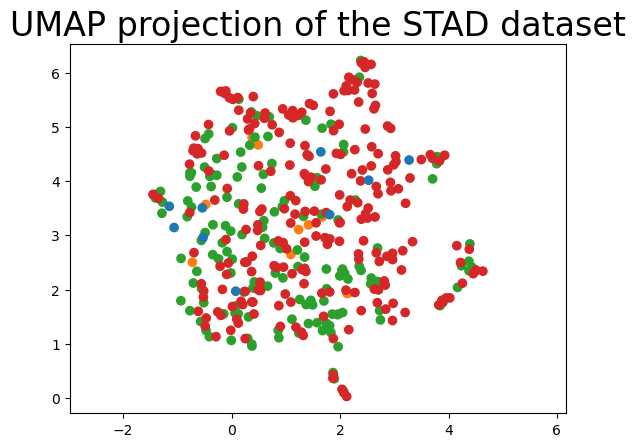

In [133]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in dfs2.neoplasm_histologic_grade.map({"G1":1,"G2":2,"G3":3,"GX":0})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the STAD dataset', fontsize=24);

In [202]:
pendigits = sklearn.datasets.load_digits()
pendigits.data.shape, pendigits.data[0]

((1797, 64),
 array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]))

### 6-1. Analyzing Training dataset

In [203]:
mapper = umap.UMAP().fit(X_Train)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

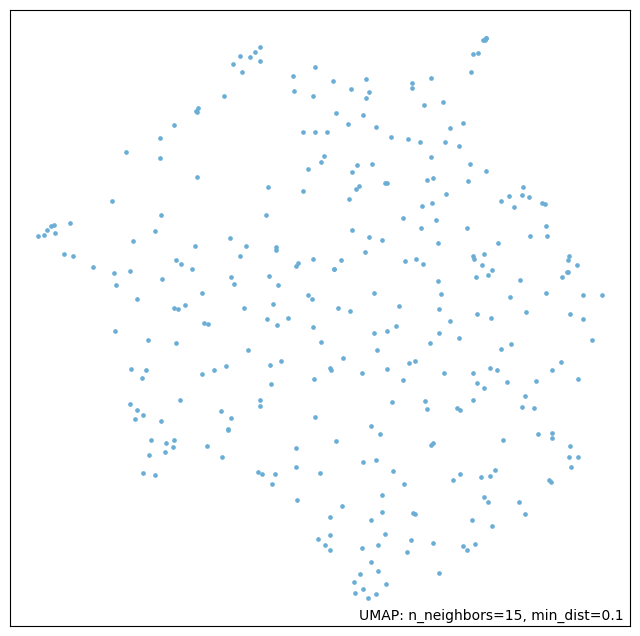

In [205]:
umap.plot.points(mapper)

In [206]:
Y_Train.shape, Y_Train[0]

((325,), 1)

<Axes: >

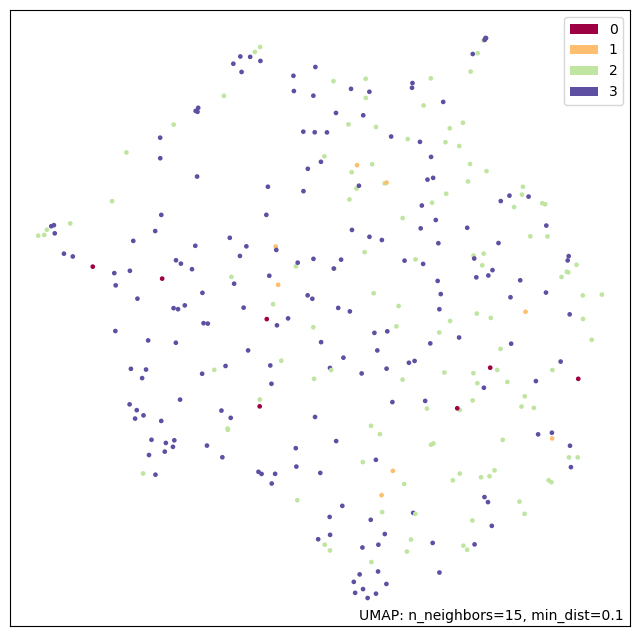

In [221]:
umap.plot.points(mapper, labels=Y_Train)#, theme='darkgreen')
# umap.plot.points(mapper, labels=Y_Train, color_key_cmap='Paired', background='black')

In [228]:
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)

In [225]:
umap.plot.output_notebook()

Loading BokehJS ...

In [229]:
p = umap.plot.interactive(mapper, labels=Y_Train, hover_data=hover_data, point_size=3)
umap.plot.show(p)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/datashader/transfer_functions/__init__.py:326: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

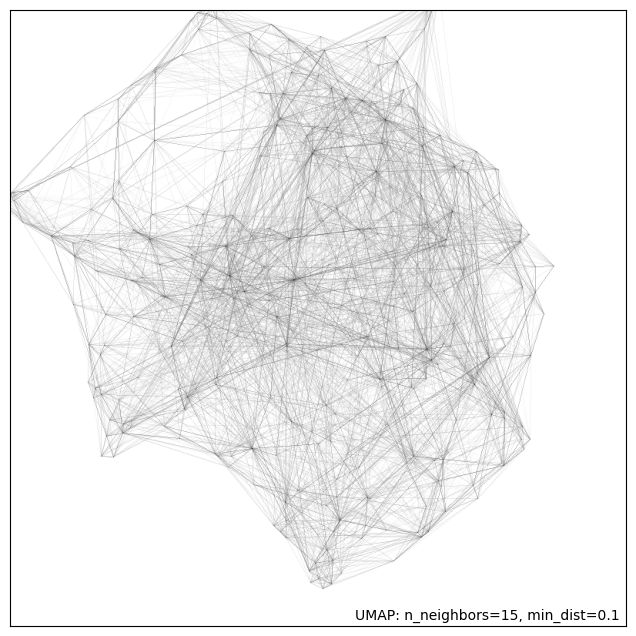

In [230]:
umap.plot.connectivity(mapper, show_points=True)

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

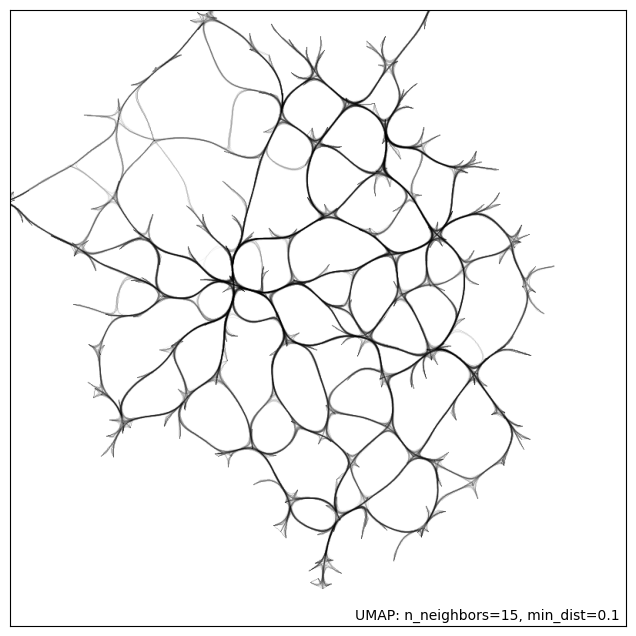

In [231]:
umap.plot.connectivity(mapper, edge_bundling='hammer')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

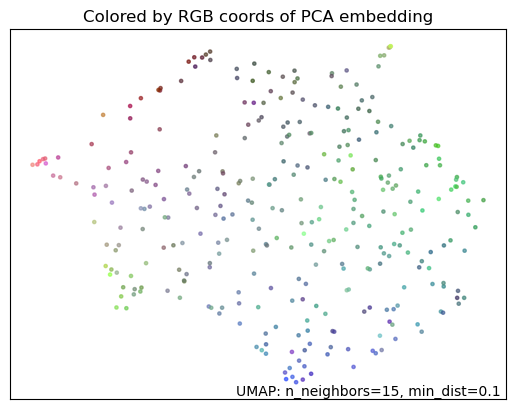

In [232]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

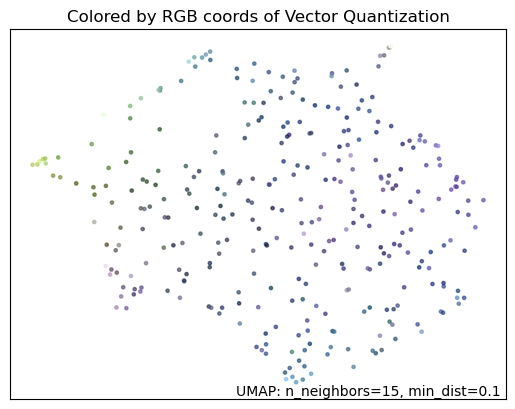

In [233]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

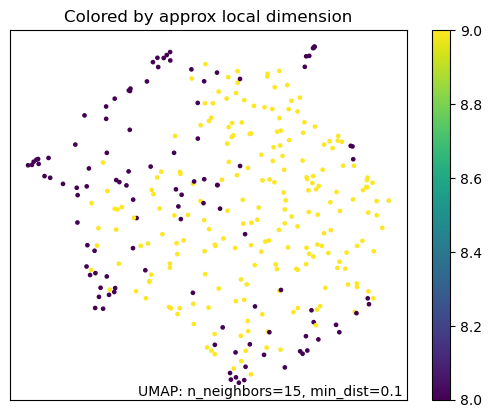

In [234]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')
# umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

### 6-2. Compute output of layers of network

In [19]:
net = Transformer_Classifier().to(device)
net.eval()
# load saved model
net2 = Transformer_Classifier().to(device)
net2.load_state_dict(T.load('./Model_save/vanila-imbedding_Adam0001_D4_F32_dr1_withoutfc2.pt'))               
net2.eval()

Transformer_Classifier(
  (embed): Embedding(843, 4)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_fe

In [20]:
# 훈련 안 된 모델에 데이터 넣어서 forward 
embedded = net.embed(train_ds.x_data)  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc1_output = T.tanh(net.fc1(z))
embedded.shape, t_encoded.shape, fc1_output.shape

(torch.Size([325, 843, 4]), torch.Size([325, 843, 4]), torch.Size([325, 32]))

In [21]:
# 훈련 된 모델에 데이터 넣어서 forward 
embedded2 = net2.embed(train_ds.x_data)  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc1_output2 = T.tanh(net2.fc1(z))
embedded2.shape, t_encoded2.shape, fc1_output2.shape

(torch.Size([325, 843, 4]), torch.Size([325, 843, 4]), torch.Size([325, 32]))

In [23]:
embedded_before = embedded.detach().cpu().numpy().reshape(325, -1)
embedded_after = embedded2.detach().cpu().numpy().reshape(325, -1)
t_encoded_before = t_encoded.detach().cpu().numpy().reshape(325, -1)
t_encoded_after = t_encoded2.detach().cpu().numpy().reshape(325, -1)
fc1_output_before = fc1_output.detach().cpu().numpy()
fc1_output_after = fc1_output2.detach().cpu().numpy()
embedded_after.shape, t_encoded_after.shape, fc1_output_after.shape

((325, 3372), (325, 3372), (325, 32))

### 6-3. Visualizing network

In [24]:
embedded_mapper_before = umap.UMAP().fit(embedded_before)
embedded_mapper_after = umap.UMAP().fit(embedded_after)

Uembedding_embedded_before = embedded_mapper_before.transform(embedded_before)
Uembedding_embedded_after = embedded_mapper_after.transform(embedded_after)

In [25]:
t_encoded_mapper_before = umap.UMAP().fit(t_encoded_before)
t_encoded_mapper_after = umap.UMAP().fit(t_encoded_after)

Uembedding_t_encoded_before = t_encoded_mapper_before.transform(t_encoded_before)
Uembedding_t_encoded_after = t_encoded_mapper_after.transform(t_encoded_after)

In [33]:
fc1_output_mapper_before = umap.UMAP().fit(fc1_output_before)
fc1_output_mapper_after = umap.UMAP().fit(fc1_output_after)

Uembedding_fc1_output_before = fc1_output_mapper_before.transform(fc1_output_before)
Uembedding_fc1_output_after = efc1_output_mapper_after.transform(fc1_output_after)

#### 6-3-1. Embdding layer before & after training

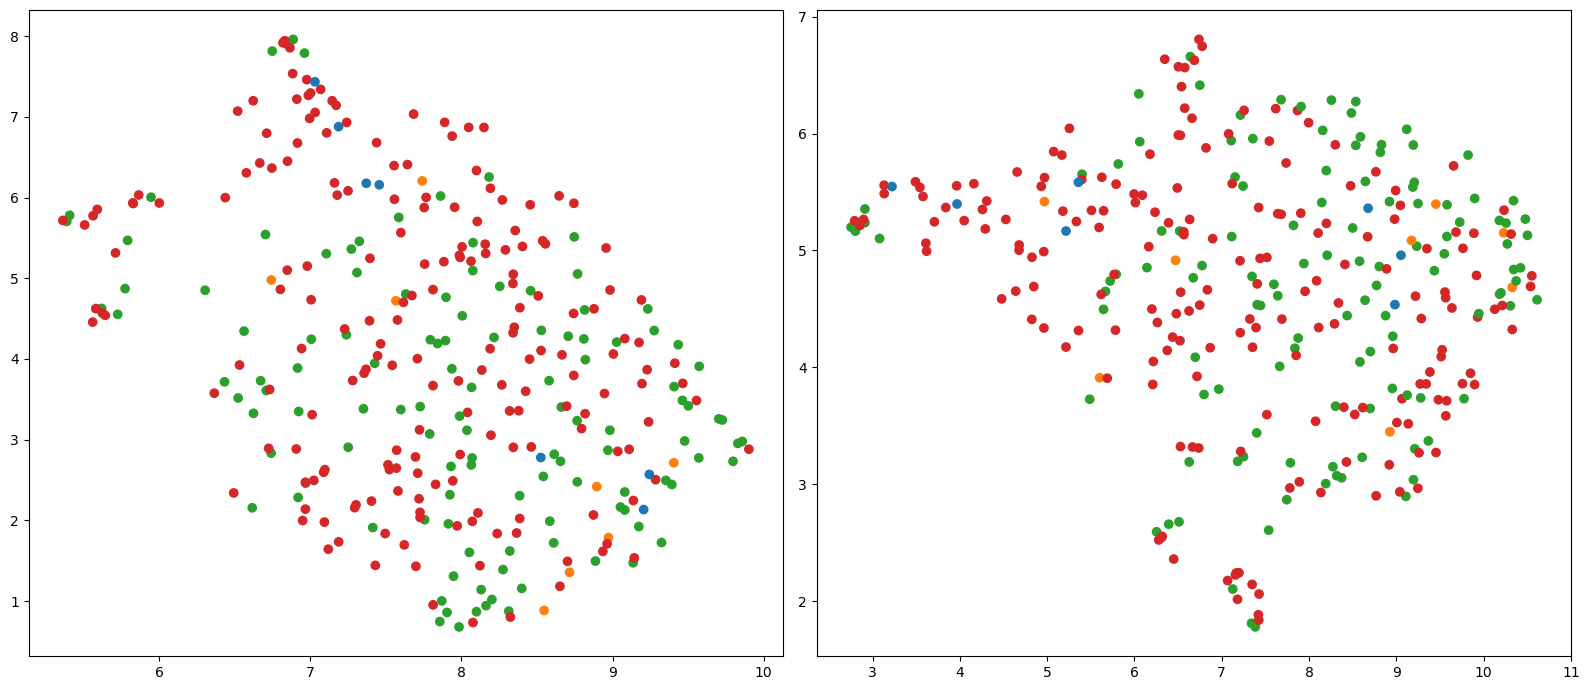

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

<Axes: >

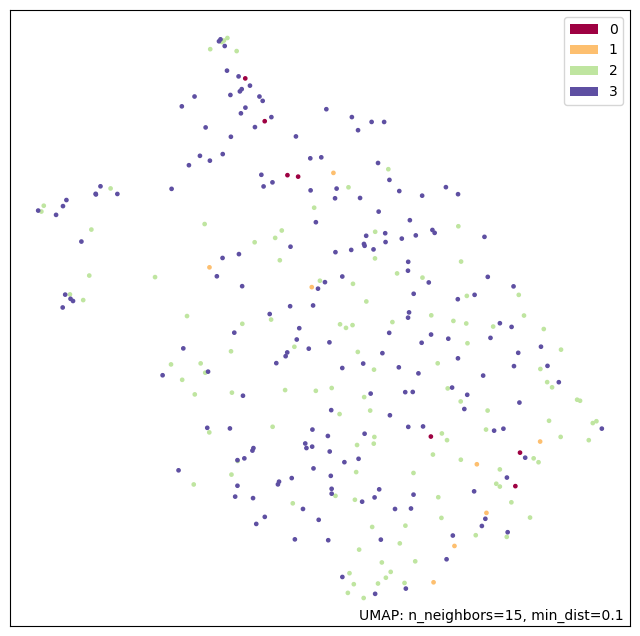

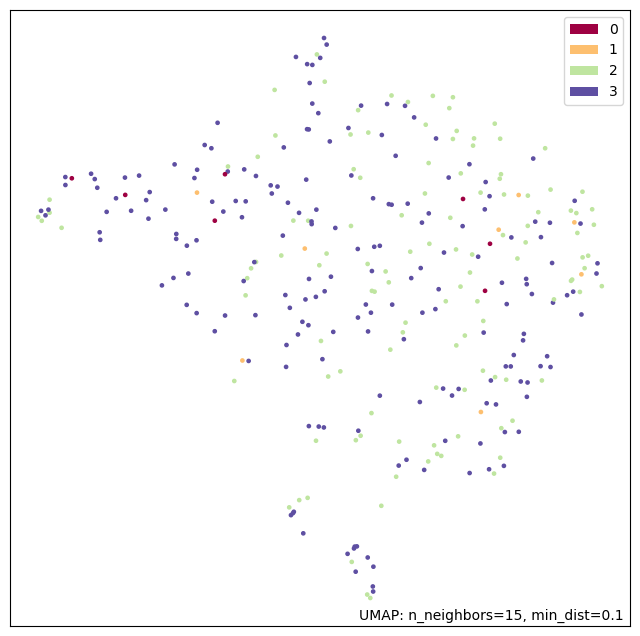

In [28]:
umap.plot.points(embedded_mapper_before, labels=Y_Train)
umap.plot.points(embedded_mapper_after, labels=Y_Train)

#### 6-3-2. Transformer Encoder before & after training

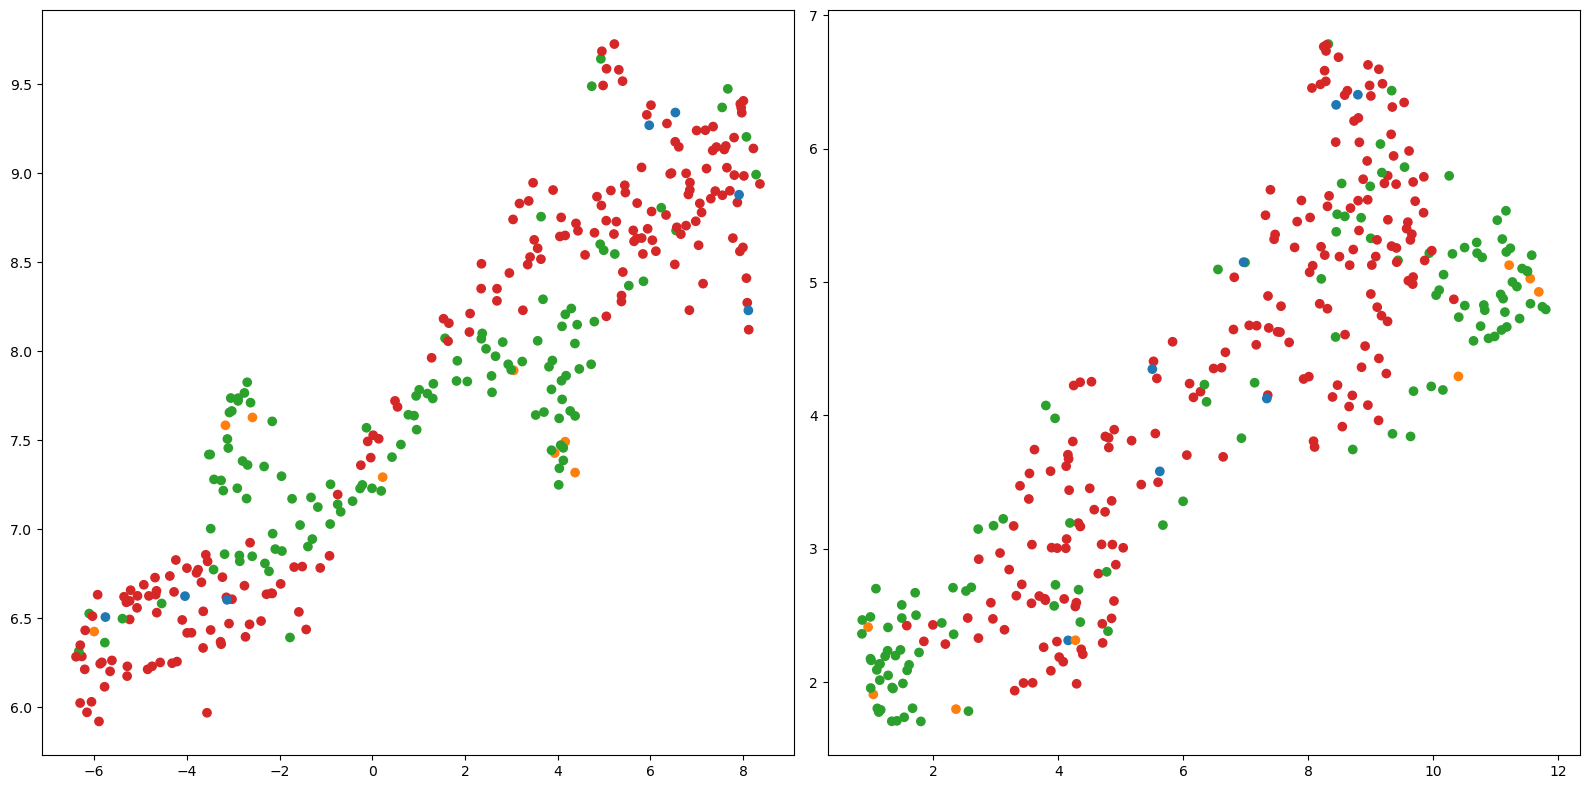

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

<Axes: >

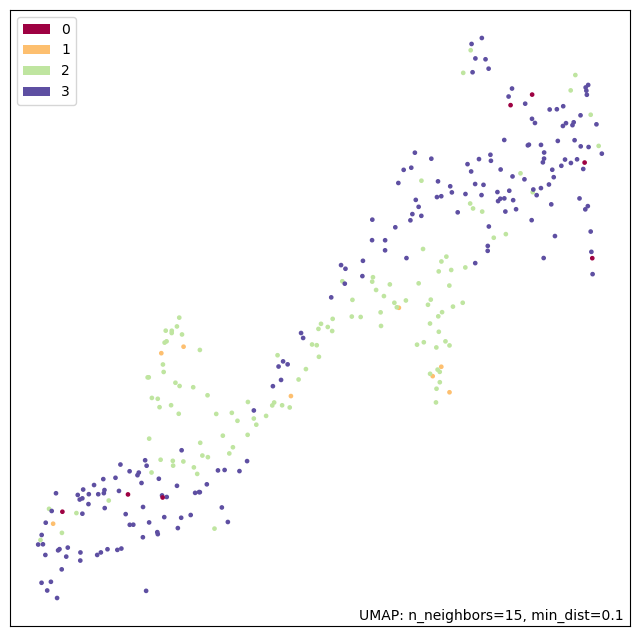

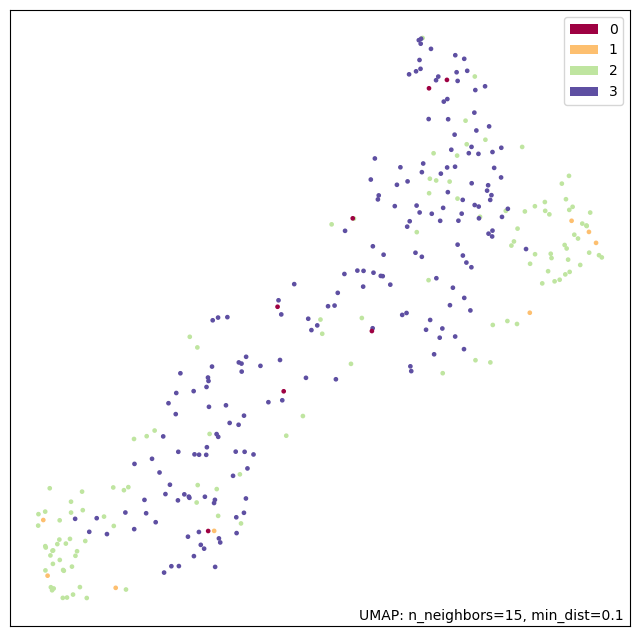

In [30]:
umap.plot.points(t_encoded_mapper_before, labels=Y_Train)
umap.plot.points(t_encoded_mapper_after, labels=Y_Train)

#### 6-3-3. Fully-Connected Layer1 before & after training

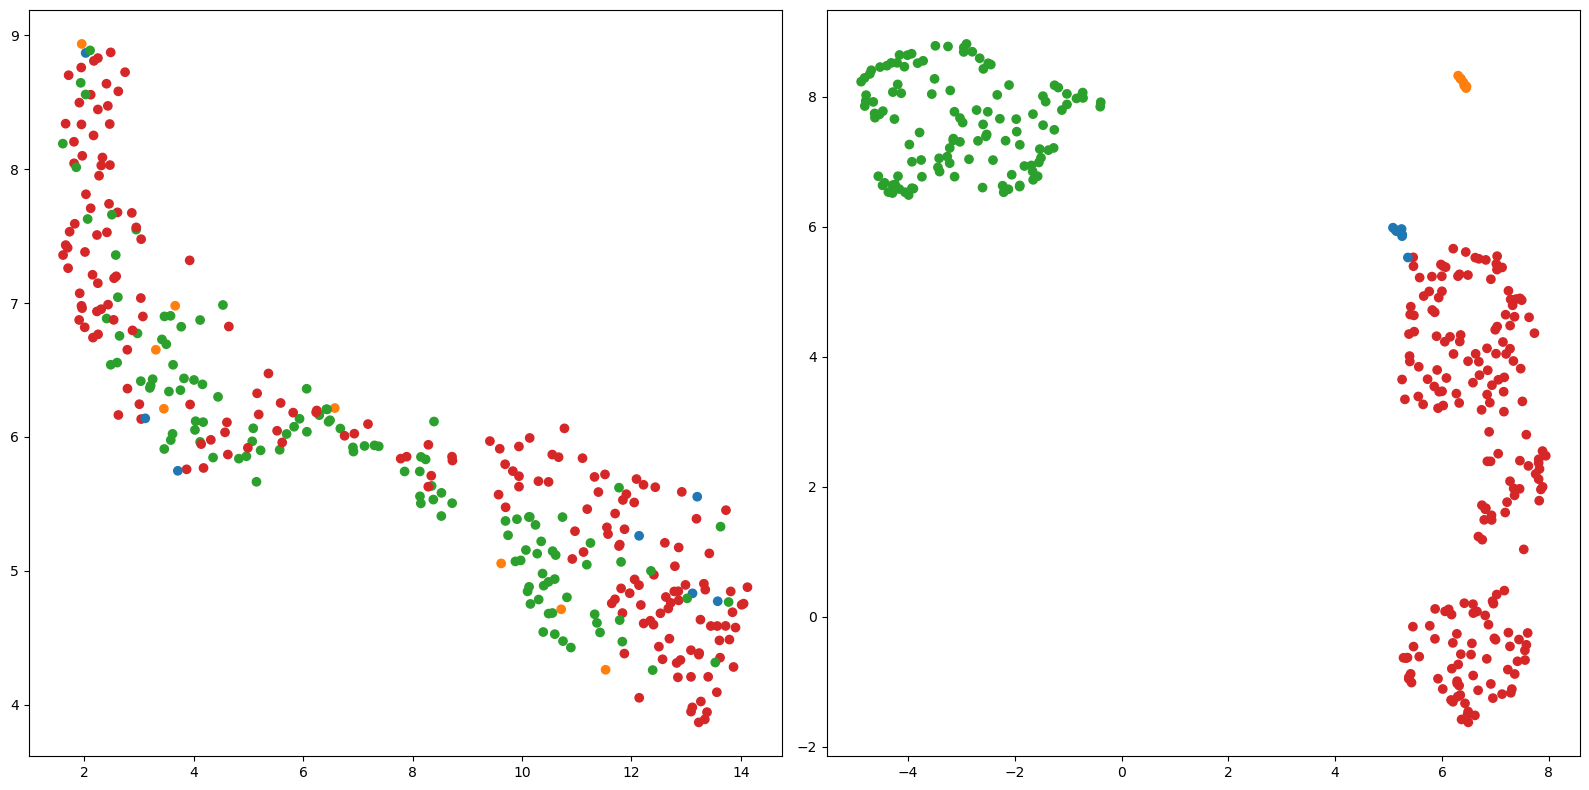

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc1_output_before[:, 0], Uembedding_fc1_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_fc1_output_after[:, 0], Uembedding_fc1_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

<Axes: >

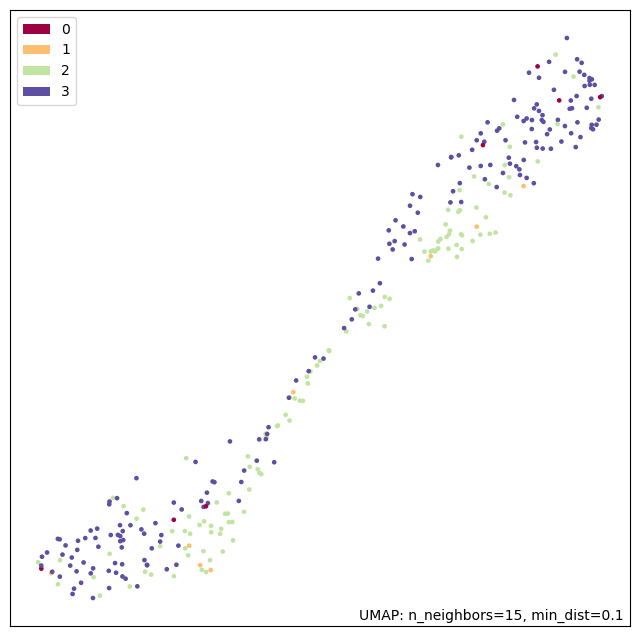

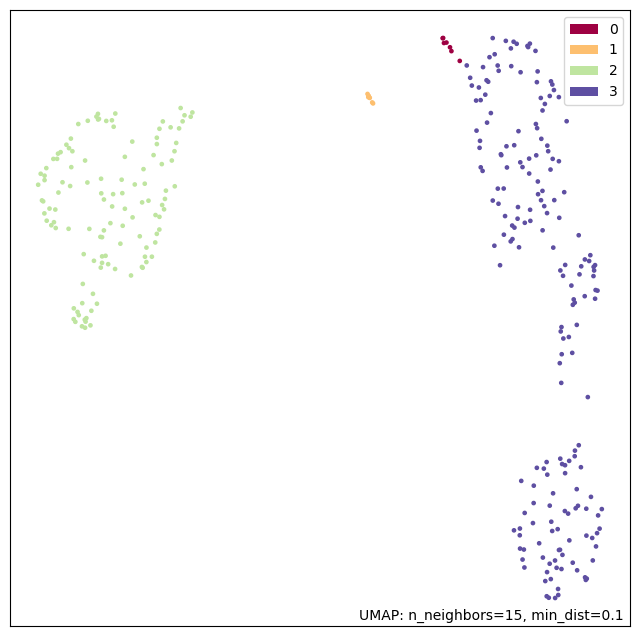

In [34]:
umap.plot.points(fc1_output_mapper_before, labels=Y_Train)
umap.plot.points(fc1_output_mapper_after, labels=Y_Train)

## 7. Inferrence

In [ ]:
X = np.array([[-1, 0.30,  0,0,1,  0.5000]], dtype=np.float32)
X = T.tensor(X, dtype=T.float32).to(device) 

with T.no_grad():
    logits = net(X)  # do not sum to 1.0
probs = T.exp(logits)  # sum to 1.0
probs = probs.numpy()  # numpy vector prints better
np.set_printoptions(precision=4, suppress=True)
print(probs)

In [ ]:
# # later
# if __name__ == "__main__":
#   main()